In [1]:
import sys; sys.path.append("..")
import numpy as np
import scipy
import matplotlib.pyplot as plt
import random
import pandas as pd
from utils.ImagePlot import ImagePlot
plotter = ImagePlot()

random.seed(42)
np.random.seed(42)

In [2]:
data = scipy.io.loadmat("./data/MNIST.mat")
X = data["X"]
Y = np.squeeze(data["I"], axis=0)

print(f"Images shape: {X.shape}")
print(f"Labels shape: {Y.shape}")

Images shape: (256, 1707)
Labels shape: (1707,)


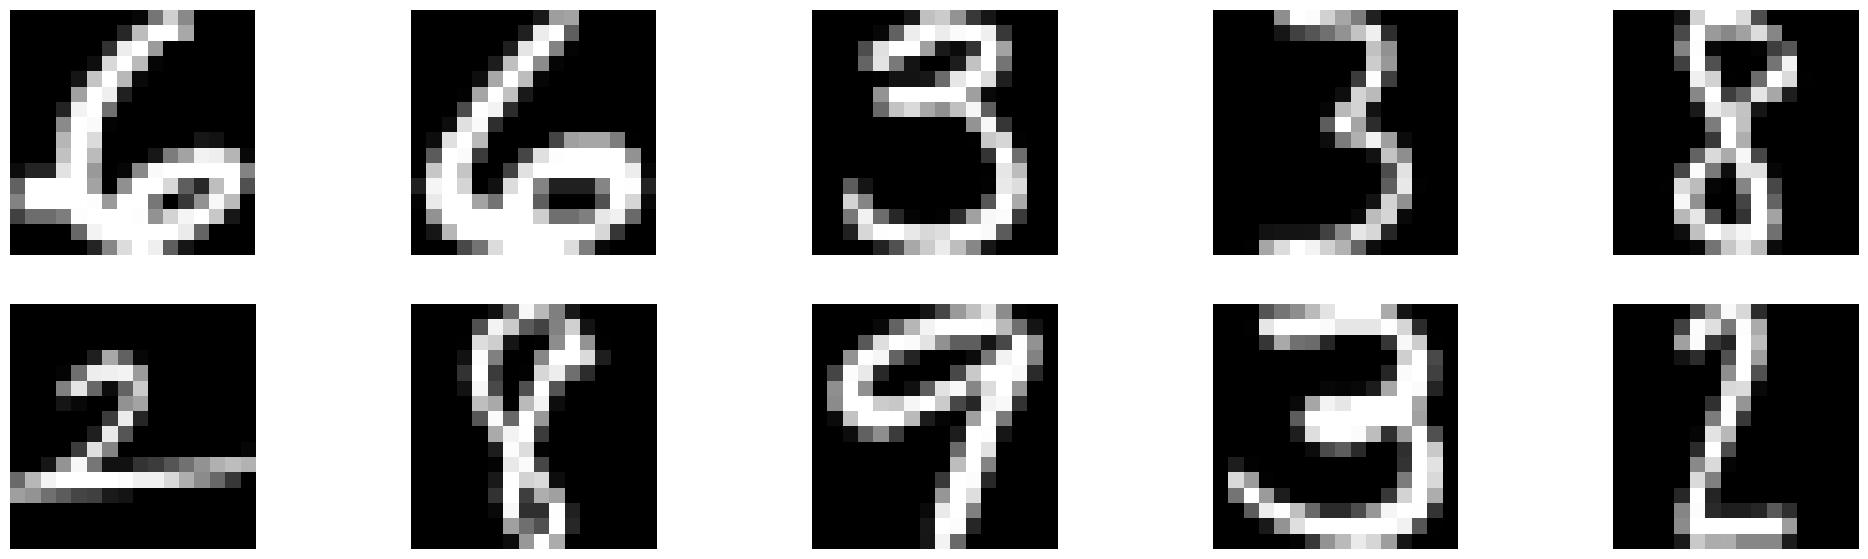

In [3]:
plotter.reset()

for i in [random.randint(0, X.shape[1]) for _ in range(10)]:
    plotter.add(X[:, i].reshape((16, 16)))

plotter.show()

## SVD computation

In [4]:
def getImagesOfDigit(digit, X, Y):
    return X[:, (Y == digit)]

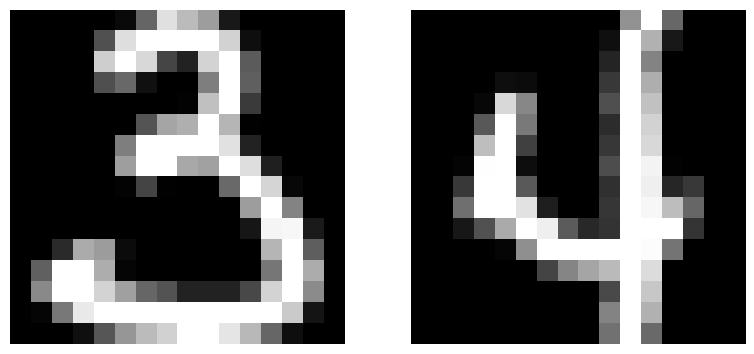

In [5]:
c1 = 3
c2 = 4
X_c1 = getImagesOfDigit(c1, X, Y)
X_c2 = getImagesOfDigit(c2, X, Y)

plotter.reset()
plotter.add(X_c1[:, 0].reshape((16, 16)))
plotter.add(X_c2[:, 0].reshape((16, 16)))
plotter.show()

## Dataset splitting

In [6]:
def split_train_test(X, train_ratio):
    train_size = int(train_ratio * X.shape[1])
    idxs = np.arange(0, X.shape[1])
    np.random.shuffle(idxs)
    return X[:, idxs[:train_size]], X[:, idxs[train_size:]]

In [7]:
X_c1_train, X_c1_test = split_train_test(X_c1, 0.75)
X_c2_train, X_c2_test = split_train_test(X_c2, 0.75)

print(f"X_c1 | train: {X_c1_train.shape[1]} -- test: {X_c1_test.shape[1]}")
print(f"X_c2 | train: {X_c2_train.shape[1]} -- test: {X_c2_test.shape[1]}")

X_c1 | train: 98 -- test: 33
X_c2 | train: 91 -- test: 31


## Binary classification

In [8]:
class MNISTBinaryClassPredict:
    def __init__(self):
        self.U1, self.c1 = None, None
        self.U2, self.c2 = None, None

    def fit(self, train_set_c1, label_c1, train_set_c2, label_c2):
        U1, _, _ = np.linalg.svd(train_set_c1, full_matrices=False)
        self.U1 = U1
        self.c1 = label_c1

        U2, _, _ = np.linalg.svd(train_set_c2, full_matrices=False)
        self.U2 = U2
        self.c2 = label_c2

    def predict(self, digit):
        y1_proj = self.U1 @ (self.U1.T @ digit)
        y2_proj = self.U2 @ (self.U2.T @ digit)

        dist1 = np.linalg.norm(digit - y1_proj, 2)
        dist2 = np.linalg.norm(digit - y2_proj, 2)

        if dist1 < dist2:
            return self.c1
        else:
            return self.c2


def evaluate(model, dataset, true_label):
    correct = 0
    for i in range(dataset.shape[1]):
        if model.predict(dataset[:, i]) == true_label:
            correct += 1
    return correct

In [9]:
def evaluateBinaryClass(c1, c2):
    X_c1 = getImagesOfDigit(c1, X, Y)
    X_c2 = getImagesOfDigit(c2, X, Y)
    X_c1_train, X_c1_test = split_train_test(X_c1, 0.75)
    X_c2_train, X_c2_test = split_train_test(X_c2, 0.75)

    model = MNISTBinaryClassPredict()
    model.fit(X_c1_train, c1, X_c2_train, c2)

    c1_correct = evaluate(model, X_c1_test, c1)
    c2_correct = evaluate(model, X_c2_test, c2)
    return c1_correct, X_c1_test.shape[1], c2_correct, X_c2_test.shape[1]


c1_correct, c1_test_size, c2_correct, c2_test_size = evaluateBinaryClass(3, 4)
print(f"Accuracy ({c1}): {c1_correct / c1_test_size:.3f} ({c1_test_size-c1_correct}/{c1_test_size} wrong)")
print(f"Accuracy ({c2}): {c2_correct / c2_test_size:.3f} ({c2_test_size-c2_correct}/{c2_test_size} wrong)")

Accuracy (3): 1.000 (0/33 wrong)
Accuracy (4): 1.000 (0/31 wrong)


Minimum overall accuracy: 0.664


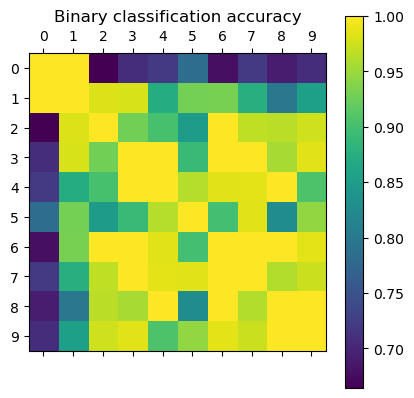

In [10]:
accuracies = np.zeros((10, 10))

for i in range(0, 10):
    for j in range(i, 10):
        c1_correct, c1_test_size, c2_correct, c2_test_size = evaluateBinaryClass(i, j)
        accuracy = (c1_correct + c2_correct) / (c1_test_size + c2_test_size)
        accuracies[i, j] = accuracies[j, i] = accuracy
        

print(f"Minimum overall accuracy: {np.min(accuracies):.3f}")

plt.matshow(accuracies)
plt.title("Binary classification accuracy")
plt.colorbar()
plt.xticks(range(0, 10))
plt.yticks(range(0, 10))
plt.show()

## Multi-class classification

In [11]:
class MNISTMultiClassPredict:
    def __init__(self):
        self.U_n = {}

    def fit(self, digits_train_sets, digits_train_labels):
        for dataset, label in zip(digits_train_sets, digits_train_labels):
            U, _, _ = np.linalg.svd(dataset, full_matrices=False)
            self.U_n[label] = U

    def predict(self, digit):
        best_dist = +np.inf
        prediction = None

        for label in self.U_n:
            U = self.U_n[label]
            proj = U @ (U.T @ digit)

            dist = np.linalg.norm(digit - proj, 2)
            if dist < best_dist:
                best_dist = dist
                prediction = label

        return prediction

In [12]:
def evaluateMultiClass(classes):
    train_sets = []
    test_sets = []

    for digit in classes:
        train, test = split_train_test(X[:, (Y == digit)], 0.75)
        train_sets.append(train)
        test_sets.append(test)

    model = MNISTMultiClassPredict()
    model.fit(train_sets, classes)

    out = []
    for label, test_set in zip(classes, test_sets):
        correct = evaluate(model, test_set, label)
        out.append((correct, test_set.shape[1]))

    return out

to_train_digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
class_res = evaluateMultiClass(to_train_digits)

for label, (correct, test_size) in zip(to_train_digits, class_res):
    print(f"{label} | Accuracy: {correct / test_size:.3f} ({test_size-correct}/{test_size} wrong)")

0 | Accuracy: 1.000 (0/80 wrong)
1 | Accuracy: 0.968 (2/63 wrong)
2 | Accuracy: 0.078 (47/51 wrong)
3 | Accuracy: 0.000 (33/33 wrong)
4 | Accuracy: 0.000 (31/31 wrong)
5 | Accuracy: 0.000 (22/22 wrong)
6 | Accuracy: 0.000 (38/38 wrong)
7 | Accuracy: 0.119 (37/42 wrong)
8 | Accuracy: 0.000 (36/36 wrong)
9 | Accuracy: 0.000 (33/33 wrong)


In [13]:
accuracies_df = pd.DataFrame(columns=["digits", "accuracy"])

for i in range(0, 10):
    for j in range(i+1, 10):
        for k in range(j+1, 10):
            class_res = evaluateMultiClass([i, j, k])
            accuracy = (class_res[0][0] + class_res[1][0] + class_res[2][0]) / (class_res[0][1] + class_res[1][1] + class_res[2][1])
            accuracies_df.loc[len(accuracies_df)] = [tuple(sorted([i, j, k])), accuracy]

# pd.set_option("display.max_rows", None)
accuracies_df = accuracies_df.sort_values("accuracy", ascending=False)

display(accuracies_df.head(10))
display(accuracies_df.tail())

,digits,accuracy
96,"(3, 6, 9)",1.000000
89,"(3, 4, 9)",1.000000
94,"(3, 6, 7)",1.000000
86,"(3, 4, 6)",1.000000
105,"(4, 6, 8)",1.000000
87,"(3, 4, 7)",1.000000
95,"(3, 6, 8)",1.000000
117,"(6, 7, 9)",0.991150
104,"(4, 6, 7)",0.990991
101,"(4, 5, 7)",0.989474


,digits,accuracy
31,"(0, 6, 8)",0.519481
13,"(0, 2, 8)",0.508982
11,"(0, 2, 6)",0.508876
8,"(0, 2, 3)",0.506098
9,"(0, 2, 4)",0.500000
